# Face Recognition Multi-Model Training on LFW
## Training 25 Models with Different Backbones and Classifier Heads

This notebook trains multiple face identification models and compares their performance.
- **Task**: Face Identification (multi-class classification)
- **Models**: 5 Backbones × 5 Classifier Heads = 25 Models
- **Output**: Best model for video face recognition

In [1]:
import os
import tarfile
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from collections import Counter
from pathlib import Path
from tqdm.auto import tqdm
import json
import time

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.amp import GradScaler, autocast
from torch.optim.lr_scheduler import CosineAnnealingLR, OneCycleLR

import torchvision.transforms as transforms
from torchvision import models

from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score, f1_score, precision_score, recall_score,
                             confusion_matrix, classification_report, top_k_accuracy_score)

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-whitegrid')

# Reproducibility
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Device setup for Kaggle dual GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
n_gpus = torch.cuda.device_count()
print(f"Device: {device}")
print(f"Number of GPUs: {n_gpus}")
if n_gpus > 0:
    for i in range(n_gpus):
        print(f"  GPU {i}: {torch.cuda.get_device_name(i)}")

Device: cuda
Number of GPUs: 2
  GPU 0: Tesla T4
  GPU 1: Tesla T4


In [2]:
# ============================================================
# KAGGLE CONFIGURATION
# ============================================================
# Set this to True when running on Kaggle
RUNNING_ON_KAGGLE = True

if RUNNING_ON_KAGGLE:
    # Data is already extracted on Kaggle at this path
    DATA_DIR = '/kaggle/input/lfw-dataset/lfw-deepfunneled/lfw-deepfunneled'
    WORK_DIR = '/kaggle/working'
    MODELS_DIR = os.path.join(WORK_DIR, 'models')
else:
    # Local paths
    WORK_DIR = '../outputs'
    DATA_DIR = '../data/lfw-deepfunneled/lfw-deepfunneled'
    MODELS_DIR = '../models/checkpoints'

os.makedirs(MODELS_DIR, exist_ok=True)
os.makedirs(WORK_DIR, exist_ok=True)

print(f"Data directory: {DATA_DIR}")
print(f"Working directory: {WORK_DIR}")
print(f"Models directory: {MODELS_DIR}")

Data directory: /kaggle/input/lfw-dataset/lfw-deepfunneled/lfw-deepfunneled
Working directory: /kaggle/working
Models directory: /kaggle/working/models


In [3]:
# Verify data exists
if os.path.exists(DATA_DIR):
    num_people = len([d for d in os.listdir(DATA_DIR) if os.path.isdir(os.path.join(DATA_DIR, d))])
    print(f"✓ Data found at {DATA_DIR}")
    print(f"  Total people directories: {num_people}")
else:
    raise FileNotFoundError(f"Data not found at {DATA_DIR}. Please check the path.")

✓ Data found at /kaggle/input/lfw-dataset/lfw-deepfunneled/lfw-deepfunneled
  Total people directories: 5749


## 1. Data Loading and Preprocessing

In [4]:
# Configuration
MIN_IMAGES_PER_PERSON = 10  # Only include people with >= N images
MAX_PEOPLE = 100  # Limit to top N people (None for all)
VAL_SPLIT = 0.2
IMG_SIZE = 224
BATCH_SIZE = 32 * max(1, n_gpus)  # Scale batch size with GPUs

print(f"Batch size: {BATCH_SIZE}")
print(f"Min images per person: {MIN_IMAGES_PER_PERSON}")
print(f"Max people: {MAX_PEOPLE}")

Batch size: 64
Min images per person: 10
Max people: 100


In [5]:
def load_lfw_dataset(data_dir, min_images=10, max_people=None):
    """Load LFW dataset for face identification."""
    people_dirs = sorted([d for d in os.listdir(data_dir) 
                          if os.path.isdir(os.path.join(data_dir, d))])
    
    # Count images per person
    person_counts = {}
    for person in people_dirs:
        person_path = os.path.join(data_dir, person)
        images = [f for f in os.listdir(person_path) if f.endswith('.jpg')]
        if len(images) >= min_images:
            person_counts[person] = len(images)
    
    # Sort by count and limit
    sorted_people = sorted(person_counts.items(), key=lambda x: x[1], reverse=True)
    if max_people:
        sorted_people = sorted_people[:max_people]
    
    # Create class mapping
    class_names = [p[0] for p in sorted_people]
    class_to_idx = {name: idx for idx, name in enumerate(class_names)}
    
    # Collect all image paths and labels
    image_paths = []
    labels = []
    
    for person in class_names:
        person_path = os.path.join(data_dir, person)
        images = [f for f in os.listdir(person_path) if f.endswith('.jpg')]
        for img in images:
            image_paths.append(os.path.join(person_path, img))
            labels.append(class_to_idx[person])
    
    return image_paths, labels, class_names

# Load dataset
image_paths, labels, class_names = load_lfw_dataset(
    DATA_DIR, 
    min_images=MIN_IMAGES_PER_PERSON,
    max_people=MAX_PEOPLE
)

num_classes = len(class_names)
print(f"\nTotal images: {len(image_paths)}")
print(f"Number of classes (people): {num_classes}")
print(f"\nFirst 10 people: {class_names[:10]}")


Total images: 3651
Number of classes (people): 100

First 10 people: ['George_W_Bush', 'Colin_Powell', 'Tony_Blair', 'Donald_Rumsfeld', 'Gerhard_Schroeder', 'Ariel_Sharon', 'Hugo_Chavez', 'Junichiro_Koizumi', 'Jean_Chretien', 'John_Ashcroft']


In [6]:
# Train/Val split
X_train, X_val, y_train, y_val = train_test_split(
    image_paths, labels, 
    test_size=VAL_SPLIT, 
    stratify=labels, 
    random_state=SEED
)

print(f"Training samples: {len(X_train)}")
print(f"Validation samples: {len(X_val)}")

Training samples: 2920
Validation samples: 731


In [7]:
# Dataset class
class FaceDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform
    
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        img = Image.open(self.image_paths[idx]).convert('RGB')
        label = self.labels[idx]
        
        if self.transform:
            img = self.transform(img)
        
        return img, label

# Transforms
train_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Create datasets and dataloaders
train_dataset = FaceDataset(X_train, y_train, transform=train_transform)
val_dataset = FaceDataset(X_val, y_val, transform=val_transform)

train_loader = DataLoader(
    train_dataset, batch_size=BATCH_SIZE, shuffle=True, 
    num_workers=4, pin_memory=True, drop_last=True
)
val_loader = DataLoader(
    val_dataset, batch_size=BATCH_SIZE, shuffle=False,
    num_workers=4, pin_memory=True
)

print(f"Train batches: {len(train_loader)}")
print(f"Val batches: {len(val_loader)}")

Train batches: 45
Val batches: 12


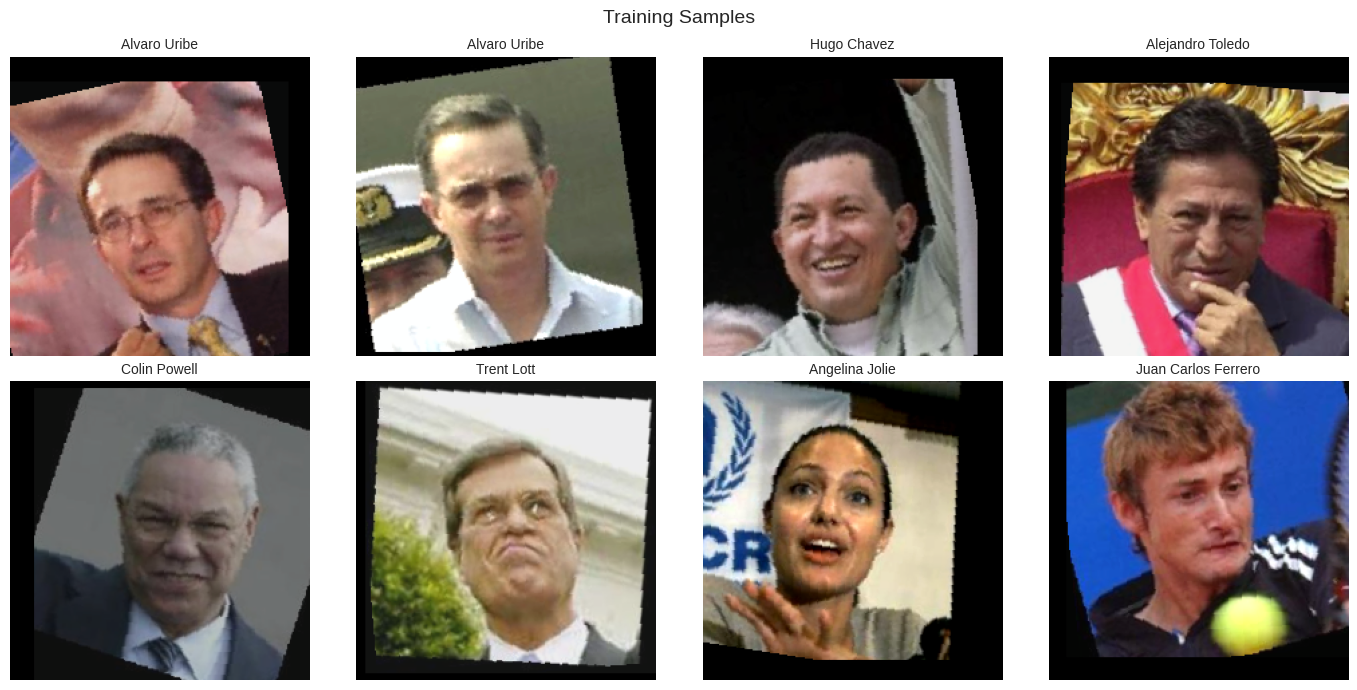

In [8]:
# Visualize samples
def show_samples(dataset, class_names, n=8):
    fig, axes = plt.subplots(2, 4, figsize=(14, 7))
    indices = np.random.choice(len(dataset), n, replace=False)
    
    for i, ax in enumerate(axes.flat):
        img, label = dataset[indices[i]]
        img = img.permute(1, 2, 0).numpy()
        img = img * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]
        img = np.clip(img, 0, 1)
        
        ax.imshow(img)
        ax.set_title(class_names[label].replace('_', ' '), fontsize=10)
        ax.axis('off')
    
    plt.suptitle('Training Samples', fontsize=14)
    plt.tight_layout()
    plt.show()

show_samples(train_dataset, class_names)

## 2. Model Architectures

In [9]:
# ============================================================
# BACKBONE DEFINITIONS
# ============================================================

def get_backbone(name, pretrained=True):
    """Get backbone network with pretrained weights."""
    if name == 'resnet50':
        model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2 if pretrained else None)
        out_features = model.fc.in_features
        model.fc = nn.Identity()
    elif name == 'resnet101':
        model = models.resnet101(weights=models.ResNet101_Weights.IMAGENET1K_V2 if pretrained else None)
        out_features = model.fc.in_features
        model.fc = nn.Identity()
    elif name == 'efficientnet_b0':
        model = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.IMAGENET1K_V1 if pretrained else None)
        out_features = model.classifier[1].in_features
        model.classifier = nn.Identity()
    elif name == 'efficientnet_b3':
        model = models.efficientnet_b3(weights=models.EfficientNet_B3_Weights.IMAGENET1K_V1 if pretrained else None)
        out_features = model.classifier[1].in_features
        model.classifier = nn.Identity()
    elif name == 'densenet121':
        model = models.densenet121(weights=models.DenseNet121_Weights.IMAGENET1K_V1 if pretrained else None)
        out_features = model.classifier.in_features
        model.classifier = nn.Identity()
    elif name == 'mobilenet_v3':
        model = models.mobilenet_v3_large(weights=models.MobileNet_V3_Large_Weights.IMAGENET1K_V2 if pretrained else None)
        out_features = model.classifier[0].in_features
        model.classifier = nn.Identity()
    elif name == 'convnext_tiny':
        model = models.convnext_tiny(weights=models.ConvNeXt_Tiny_Weights.IMAGENET1K_V1 if pretrained else None)
        out_features = model.classifier[2].in_features
        # Keep LayerNorm2d and Flatten, only remove the Linear layer
        model.classifier = nn.Sequential(
            model.classifier[0],  # LayerNorm2d
            model.classifier[1],  # Flatten
        )
    else:
        raise ValueError(f"Unknown backbone: {name}")
    
    return model, out_features

# Test backbone loading
test_backbone, test_features = get_backbone('resnet50')
print(f"ResNet50 output features: {test_features}")
del test_backbone

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 189MB/s]


ResNet50 output features: 2048


In [10]:
# ============================================================
# CLASSIFIER HEAD DEFINITIONS
# ============================================================

class SimpleHead(nn.Module):
    """Simple linear classifier head."""
    def __init__(self, in_features, num_classes, dropout=0.5):
        super().__init__()
        self.head = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(in_features, num_classes)
        )
    
    def forward(self, x):
        return self.head(x)

class MLPHead(nn.Module):
    """Multi-layer perceptron head."""
    def __init__(self, in_features, num_classes, hidden_dim=512, dropout=0.5):
        super().__init__()
        self.head = nn.Sequential(
            nn.Linear(in_features, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, num_classes)
        )
    
    def forward(self, x):
        return self.head(x)

class DeepHead(nn.Module):
    """Deep MLP head with 2 hidden layers."""
    def __init__(self, in_features, num_classes, hidden_dim=512, dropout=0.5):
        super().__init__()
        self.head = nn.Sequential(
            nn.Linear(in_features, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.BatchNorm1d(hidden_dim // 2),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout / 2),
            nn.Linear(hidden_dim // 2, num_classes)
        )
    
    def forward(self, x):
        return self.head(x)

class AttentionHead(nn.Module):
    """Attention-based classifier head."""
    def __init__(self, in_features, num_classes, hidden_dim=512, dropout=0.5):
        super().__init__()
        self.attention = nn.Sequential(
            nn.Linear(in_features, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, 1),
            nn.Softmax(dim=1)
        )
        self.fc = nn.Sequential(
            nn.Linear(in_features, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, num_classes)
        )
    
    def forward(self, x):
        # For 1D features, attention simplifies to weighted FC
        return self.fc(x)

class CosFaceHead(nn.Module):
    """CosFace/ArcFace style head with normalized weights."""
    def __init__(self, in_features, num_classes, hidden_dim=512, dropout=0.5, s=30.0, m=0.35):
        super().__init__()
        self.s = s
        self.m = m
        self.projection = nn.Sequential(
            nn.Linear(in_features, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout)
        )
        self.weight = nn.Parameter(torch.FloatTensor(num_classes, hidden_dim))
        nn.init.xavier_uniform_(self.weight)
    
    def forward(self, x, labels=None):
        x = self.projection(x)
        # Normalize features and weights
        x_norm = F.normalize(x, p=2, dim=1)
        w_norm = F.normalize(self.weight, p=2, dim=1)
        # Cosine similarity
        cosine = F.linear(x_norm, w_norm)
        # Scale
        output = self.s * cosine
        return output

# Head factory
def get_head(name, in_features, num_classes, dropout=0.5):
    """Get classifier head by name."""
    heads = {
        'simple': SimpleHead,
        'mlp': MLPHead,
        'deep': DeepHead,
        'attention': AttentionHead,
        'cosface': CosFaceHead
    }
    if name not in heads:
        raise ValueError(f"Unknown head: {name}")
    return heads[name](in_features, num_classes, dropout=dropout)

In [11]:
# ============================================================
# COMPLETE FACE CLASSIFIER MODEL
# ============================================================

class FaceClassifier(nn.Module):
    """Face identification model with configurable backbone and head."""
    
    def __init__(self, num_classes, backbone_name='resnet50', head_name='mlp', 
                 pretrained=True, dropout=0.5):
        super().__init__()
        self.backbone_name = backbone_name
        self.head_name = head_name
        self.num_classes = num_classes
        
        # Load backbone
        self.backbone, out_features = get_backbone(backbone_name, pretrained)
        
        # Create classifier head
        self.head = get_head(head_name, out_features, num_classes, dropout)
    
    def forward(self, x):
        features = self.backbone(x)
        if isinstance(features, tuple):
            features = features[0]
        return self.head(features)
    
    def predict(self, x):
        """Get predictions and probabilities."""
        self.eval()
        with torch.no_grad():
            logits = self.forward(x)
            probs = F.softmax(logits, dim=1)
            preds = logits.argmax(dim=1)
        return preds, probs

# Test model creation
test_model = FaceClassifier(num_classes=100, backbone_name='resnet50', head_name='mlp')
print(f"Model parameters: {sum(p.numel() for p in test_model.parameters()):,}")
del test_model

Model parameters: 24,609,444


## 3. Training Functions

In [12]:
def train_epoch(model, loader, criterion, optimizer, scaler, device):
    """Train for one epoch."""
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    
    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        with autocast(device_type='cuda'):
            outputs = model(images)
            loss = criterion(outputs, labels)
        
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        
        total_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
    
    return total_loss / len(loader), 100.0 * correct / total


def validate_epoch(model, loader, criterion, device):
    """Validate for one epoch."""
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    all_probs = []
    
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            
            with autocast(device_type='cuda'):
                outputs = model(images)
                loss = criterion(outputs, labels)
            
            total_loss += loss.item()
            probs = F.softmax(outputs, dim=1)
            _, predicted = outputs.max(1)
            
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())
    
    accuracy = 100.0 * correct / total
    
    # Calculate additional metrics
    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)
    all_probs = np.array(all_probs)
    
    f1 = f1_score(all_labels, all_preds, average='weighted')
    top5_acc = top_k_accuracy_score(all_labels, all_probs, k=5) * 100
    
    return total_loss / len(loader), accuracy, f1, top5_acc

In [13]:
def train_model(backbone_name, head_name, train_loader, val_loader, 
                num_classes, epochs=10, lr=1e-4, device='cuda'):
    """Train a single model configuration."""
    model_name = f"{backbone_name}_{head_name}"
    print(f"\n{'='*60}")
    print(f"Training: {model_name}")
    print(f"{'='*60}")
    
    # Create model
    model = FaceClassifier(
        num_classes=num_classes,
        backbone_name=backbone_name,
        head_name=head_name,
        pretrained=True,
        dropout=0.5
    )
    
    # Multi-GPU support
    if n_gpus > 1:
        model = nn.DataParallel(model)
    model = model.to(device)
    
    # Training setup
    criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=0.01)
    scheduler = CosineAnnealingLR(optimizer, T_max=epochs, eta_min=lr/100)
    scaler = GradScaler()
    
    # Training history
    history = {
        'train_loss': [], 'train_acc': [],
        'val_loss': [], 'val_acc': [],
        'val_f1': [], 'val_top5': []
    }
    
    best_acc = 0
    best_model_state = None
    
    # Training loop
    pbar = tqdm(range(epochs), desc=f"Training {model_name}")
    for epoch in pbar:
        # Train
        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, scaler, device)
        
        # Validate
        val_loss, val_acc, val_f1, val_top5 = validate_epoch(model, val_loader, criterion, device)
        
        # Update scheduler
        scheduler.step()
        
        # Save history
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        history['val_f1'].append(val_f1)
        history['val_top5'].append(val_top5)
        
        # Save best model
        if val_acc > best_acc:
            best_acc = val_acc
            model_to_save = model.module if hasattr(model, 'module') else model
            best_model_state = model_to_save.state_dict().copy()
        
        pbar.set_postfix({
            'loss': f"{train_loss:.4f}",
            'acc': f"{train_acc:.1f}%",
            'val_acc': f"{val_acc:.1f}%",
            'top5': f"{val_top5:.1f}%"
        })
    
    # Final results
    results = {
        'model_name': model_name,
        'backbone': backbone_name,
        'head': head_name,
        'best_val_acc': best_acc,
        'final_val_acc': history['val_acc'][-1],
        'final_val_f1': history['val_f1'][-1],
        'final_val_top5': history['val_top5'][-1],
        'final_train_acc': history['train_acc'][-1],
        'history': history
    }
    
    print(f"  Best Val Accuracy: {best_acc:.2f}%")
    print(f"  Final Top-5 Accuracy: {val_top5:.2f}%")
    
    return results, best_model_state, model

## 4. Train All 25 Models

In [14]:
# ============================================================
# MODEL CONFIGURATIONS
# ============================================================

BACKBONES = ['resnet50', 'efficientnet_b0', 'densenet121', 'mobilenet_v3', 'convnext_tiny']
HEADS = ['simple', 'mlp', 'deep', 'attention', 'cosface']

# Training hyperparameters
EPOCHS = 10 
LEARNING_RATE = 1e-4

print(f"Total models to train: {len(BACKBONES)} x {len(HEADS)} = {len(BACKBONES) * len(HEADS)}")
print(f"\nBackbones: {BACKBONES}")
print(f"Heads: {HEADS}")
print(f"\nEpochs: {EPOCHS}")
print(f"Learning rate: {LEARNING_RATE}")

Total models to train: 5 x 5 = 25

Backbones: ['resnet50', 'efficientnet_b0', 'densenet121', 'mobilenet_v3', 'convnext_tiny']
Heads: ['simple', 'mlp', 'deep', 'attention', 'cosface']

Epochs: 10
Learning rate: 0.0001


In [15]:
# Train all models
all_results = {}
all_model_states = {}

total_models = len(BACKBONES) * len(HEADS)
current_model = 0

for backbone_name in BACKBONES:
    for head_name in HEADS:
        current_model += 1
        print(f"\n[{current_model}/{total_models}] Training {backbone_name} + {head_name}")
        
        try:
            results, model_state, model = train_model(
                backbone_name=backbone_name,
                head_name=head_name,
                train_loader=train_loader,
                val_loader=val_loader,
                num_classes=num_classes,
                epochs=EPOCHS,
                lr=LEARNING_RATE,
                device=device
            )
            
            model_name = f"{backbone_name}_{head_name}"
            all_results[model_name] = results
            all_model_states[model_name] = model_state
            
            # Save individual model
            save_path = os.path.join(MODELS_DIR, f"{model_name}.pt")
            torch.save({
                'model_state_dict': model_state,
                'backbone': backbone_name,
                'head': head_name,
                'num_classes': num_classes,
                'class_names': class_names,
                'results': results
            }, save_path)
            print(f"  Saved to {save_path}")
            
            # Clean up
            del model
            torch.cuda.empty_cache()
            
        except Exception as e:
            print(f"  ERROR: {str(e)}")
            continue

print(f"\n{'='*60}")
print(f"Training complete! {len(all_results)} models trained successfully.")
print(f"{'='*60}")


[1/25] Training resnet50 + simple

Training: resnet50_simple


Training resnet50_simple:   0%|          | 0/10 [00:00<?, ?it/s]

  Best Val Accuracy: 88.37%
  Final Top-5 Accuracy: 97.40%
  Saved to /kaggle/working/models/resnet50_simple.pt

[2/25] Training resnet50 + mlp

Training: resnet50_mlp


Training resnet50_mlp:   0%|          | 0/10 [00:00<?, ?it/s]

  Best Val Accuracy: 82.49%
  Final Top-5 Accuracy: 94.53%
  Saved to /kaggle/working/models/resnet50_mlp.pt

[3/25] Training resnet50 + deep

Training: resnet50_deep


Training resnet50_deep:   0%|          | 0/10 [00:00<?, ?it/s]

  Best Val Accuracy: 57.46%
  Final Top-5 Accuracy: 76.74%
  Saved to /kaggle/working/models/resnet50_deep.pt

[4/25] Training resnet50 + attention

Training: resnet50_attention


Training resnet50_attention:   0%|          | 0/10 [00:00<?, ?it/s]

  Best Val Accuracy: 80.85%
  Final Top-5 Accuracy: 94.66%
  Saved to /kaggle/working/models/resnet50_attention.pt

[5/25] Training resnet50 + cosface

Training: resnet50_cosface


Training resnet50_cosface:   0%|          | 0/10 [00:00<?, ?it/s]

  Best Val Accuracy: 84.68%
  Final Top-5 Accuracy: 96.03%
  Saved to /kaggle/working/models/resnet50_cosface.pt

[6/25] Training efficientnet_b0 + simple

Training: efficientnet_b0_simple
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth


100%|██████████| 20.5M/20.5M [00:00<00:00, 126MB/s] 


Training efficientnet_b0_simple:   0%|          | 0/10 [00:00<?, ?it/s]

  Best Val Accuracy: 58.96%
  Final Top-5 Accuracy: 82.22%
  Saved to /kaggle/working/models/efficientnet_b0_simple.pt

[7/25] Training efficientnet_b0 + mlp

Training: efficientnet_b0_mlp


Training efficientnet_b0_mlp:   0%|          | 0/10 [00:00<?, ?it/s]

  Best Val Accuracy: 63.61%
  Final Top-5 Accuracy: 84.40%
  Saved to /kaggle/working/models/efficientnet_b0_mlp.pt

[8/25] Training efficientnet_b0 + deep

Training: efficientnet_b0_deep


Training efficientnet_b0_deep:   0%|          | 0/10 [00:00<?, ?it/s]

  Best Val Accuracy: 45.42%
  Final Top-5 Accuracy: 68.40%
  Saved to /kaggle/working/models/efficientnet_b0_deep.pt

[9/25] Training efficientnet_b0 + attention

Training: efficientnet_b0_attention


Training efficientnet_b0_attention:   0%|          | 0/10 [00:00<?, ?it/s]

  Best Val Accuracy: 63.89%
  Final Top-5 Accuracy: 84.95%
  Saved to /kaggle/working/models/efficientnet_b0_attention.pt

[10/25] Training efficientnet_b0 + cosface

Training: efficientnet_b0_cosface


Training efficientnet_b0_cosface:   0%|          | 0/10 [00:00<?, ?it/s]

  Best Val Accuracy: 72.50%
  Final Top-5 Accuracy: 89.47%
  Saved to /kaggle/working/models/efficientnet_b0_cosface.pt

[11/25] Training densenet121 + simple

Training: densenet121_simple
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth


100%|██████████| 30.8M/30.8M [00:00<00:00, 177MB/s]


Training densenet121_simple:   0%|          | 0/10 [00:00<?, ?it/s]

  Best Val Accuracy: 76.33%
  Final Top-5 Accuracy: 92.07%
  Saved to /kaggle/working/models/densenet121_simple.pt

[12/25] Training densenet121 + mlp

Training: densenet121_mlp


Training densenet121_mlp:   0%|          | 0/10 [00:00<?, ?it/s]

  Best Val Accuracy: 80.03%
  Final Top-5 Accuracy: 93.98%
  Saved to /kaggle/working/models/densenet121_mlp.pt

[13/25] Training densenet121 + deep

Training: densenet121_deep


Training densenet121_deep:   0%|          | 0/10 [00:00<?, ?it/s]

  Best Val Accuracy: 57.46%
  Final Top-5 Accuracy: 77.98%
  Saved to /kaggle/working/models/densenet121_deep.pt

[14/25] Training densenet121 + attention

Training: densenet121_attention


Training densenet121_attention:   0%|          | 0/10 [00:00<?, ?it/s]

  Best Val Accuracy: 79.34%
  Final Top-5 Accuracy: 93.57%
  Saved to /kaggle/working/models/densenet121_attention.pt

[15/25] Training densenet121 + cosface

Training: densenet121_cosface


Training densenet121_cosface:   0%|          | 0/10 [00:00<?, ?it/s]

  Best Val Accuracy: 87.28%
  Final Top-5 Accuracy: 95.35%
  Saved to /kaggle/working/models/densenet121_cosface.pt

[16/25] Training mobilenet_v3 + simple

Training: mobilenet_v3_simple
Downloading: "https://download.pytorch.org/models/mobilenet_v3_large-5c1a4163.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_large-5c1a4163.pth


100%|██████████| 21.1M/21.1M [00:00<00:00, 141MB/s] 


Training mobilenet_v3_simple:   0%|          | 0/10 [00:00<?, ?it/s]

  Best Val Accuracy: 59.23%
  Final Top-5 Accuracy: 80.85%
  Saved to /kaggle/working/models/mobilenet_v3_simple.pt

[17/25] Training mobilenet_v3 + mlp

Training: mobilenet_v3_mlp


Training mobilenet_v3_mlp:   0%|          | 0/10 [00:00<?, ?it/s]

  Best Val Accuracy: 61.15%
  Final Top-5 Accuracy: 82.76%
  Saved to /kaggle/working/models/mobilenet_v3_mlp.pt

[18/25] Training mobilenet_v3 + deep

Training: mobilenet_v3_deep


Training mobilenet_v3_deep:   0%|          | 0/10 [00:00<?, ?it/s]

  Best Val Accuracy: 46.92%
  Final Top-5 Accuracy: 68.40%
  Saved to /kaggle/working/models/mobilenet_v3_deep.pt

[19/25] Training mobilenet_v3 + attention

Training: mobilenet_v3_attention


Training mobilenet_v3_attention:   0%|          | 0/10 [00:00<?, ?it/s]

  Best Val Accuracy: 62.93%
  Final Top-5 Accuracy: 84.27%
  Saved to /kaggle/working/models/mobilenet_v3_attention.pt

[20/25] Training mobilenet_v3 + cosface

Training: mobilenet_v3_cosface


Training mobilenet_v3_cosface:   0%|          | 0/10 [00:00<?, ?it/s]

  Best Val Accuracy: 70.86%
  Final Top-5 Accuracy: 88.37%
  Saved to /kaggle/working/models/mobilenet_v3_cosface.pt

[21/25] Training convnext_tiny + simple

Training: convnext_tiny_simple
Downloading: "https://download.pytorch.org/models/convnext_tiny-983f1562.pth" to /root/.cache/torch/hub/checkpoints/convnext_tiny-983f1562.pth


100%|██████████| 109M/109M [00:00<00:00, 180MB/s]


Training convnext_tiny_simple:   0%|          | 0/10 [00:00<?, ?it/s]

  Best Val Accuracy: 94.80%
  Final Top-5 Accuracy: 97.81%
  Saved to /kaggle/working/models/convnext_tiny_simple.pt

[22/25] Training convnext_tiny + mlp

Training: convnext_tiny_mlp


Training convnext_tiny_mlp:   0%|          | 0/10 [00:00<?, ?it/s]

  Best Val Accuracy: 88.37%
  Final Top-5 Accuracy: 96.72%
  Saved to /kaggle/working/models/convnext_tiny_mlp.pt

[23/25] Training convnext_tiny + deep

Training: convnext_tiny_deep


Training convnext_tiny_deep:   0%|          | 0/10 [00:00<?, ?it/s]

  Best Val Accuracy: 63.75%
  Final Top-5 Accuracy: 86.46%
  Saved to /kaggle/working/models/convnext_tiny_deep.pt

[24/25] Training convnext_tiny + attention

Training: convnext_tiny_attention


Training convnext_tiny_attention:   0%|          | 0/10 [00:00<?, ?it/s]

  Best Val Accuracy: 86.05%
  Final Top-5 Accuracy: 96.85%
  Saved to /kaggle/working/models/convnext_tiny_attention.pt

[25/25] Training convnext_tiny + cosface

Training: convnext_tiny_cosface


Training convnext_tiny_cosface:   0%|          | 0/10 [00:00<?, ?it/s]

  Best Val Accuracy: 92.75%
  Final Top-5 Accuracy: 97.95%
  Saved to /kaggle/working/models/convnext_tiny_cosface.pt

Training complete! 25 models trained successfully.


## 5. Results Analysis

In [16]:
# Create results DataFrame
results_data = []
for name, res in all_results.items():
    results_data.append({
        'Model': name,
        'Backbone': res['backbone'],
        'Head': res['head'],
        'Train Acc': res['final_train_acc'],
        'Val Acc': res['final_val_acc'],
        'Best Val Acc': res['best_val_acc'],
        'Val F1': res['final_val_f1'],
        'Top-5 Acc': res['final_val_top5']
    })

results_df = pd.DataFrame(results_data)
results_df = results_df.sort_values('Best Val Acc', ascending=False)

print("\nAll Models Ranked by Validation Accuracy:")
print("="*80)
display(results_df.style.highlight_max(subset=['Train Acc', 'Val Acc', 'Best Val Acc', 'Val F1', 'Top-5 Acc']))


All Models Ranked by Validation Accuracy:


,Model,Backbone,Head,Train Acc,Val Acc,Best Val Acc,Val F1,Top-5 Acc
20,convnext_tiny_simple,convnext_tiny,simple,96.979167,94.801642,94.801642,0.946637,97.811218
24,convnext_tiny_cosface,convnext_tiny,cosface,92.395833,92.749658,92.749658,0.923838,97.948016
21,convnext_tiny_mlp,convnext_tiny,mlp,89.305556,88.098495,88.372093,0.858520,96.716826
0,resnet50_simple,resnet50,simple,91.597222,88.372093,88.372093,0.872185,97.400821
14,densenet121_cosface,densenet121,cosface,87.743056,87.277702,87.277702,0.856636,95.348837
23,convnext_tiny_attention,convnext_tiny,attention,87.222222,86.046512,86.046512,0.841477,96.853625
4,resnet50_cosface,resnet50,cosface,87.013889,84.678523,84.678523,0.837015,96.032832
1,resnet50_mlp,resnet50,mlp,84.791667,82.352941,82.489740,0.789975,94.528044
3,resnet50_attention,resnet50,attention,85.277778,80.848153,80.848153,0.773460,94.664843
11,densenet121_mlp,densenet121,mlp,82.812500,80.027360,80.027360,0.755001,93.980848


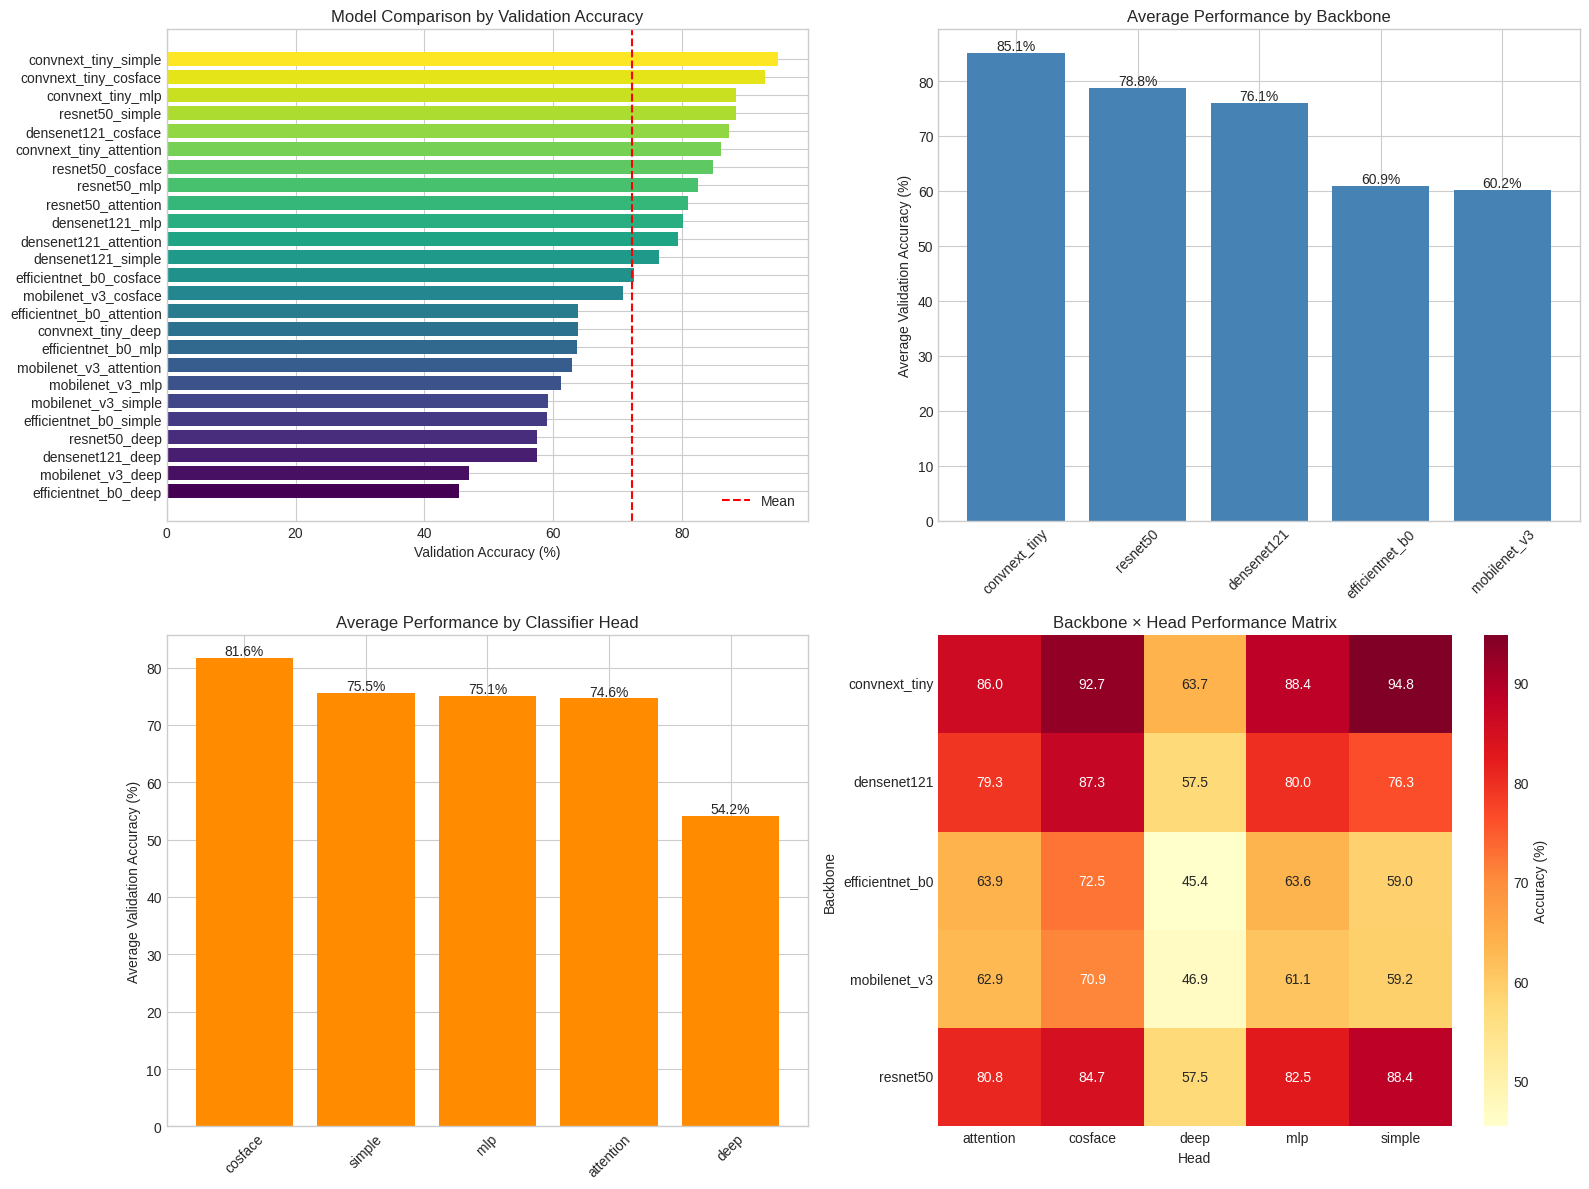

In [17]:
# Visualize results
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Validation Accuracy by Model
ax = axes[0, 0]
sorted_results = results_df.sort_values('Best Val Acc', ascending=True)
colors = plt.cm.viridis(np.linspace(0, 1, len(sorted_results)))
ax.barh(sorted_results['Model'], sorted_results['Best Val Acc'], color=colors)
ax.set_xlabel('Validation Accuracy (%)')
ax.set_title('Model Comparison by Validation Accuracy')
ax.axvline(sorted_results['Best Val Acc'].mean(), color='red', linestyle='--', label='Mean')
ax.legend()

# 2. Backbone Comparison
ax = axes[0, 1]
backbone_avg = results_df.groupby('Backbone')['Best Val Acc'].mean().sort_values(ascending=False)
ax.bar(backbone_avg.index, backbone_avg.values, color='steelblue')
ax.set_ylabel('Average Validation Accuracy (%)')
ax.set_title('Average Performance by Backbone')
ax.tick_params(axis='x', rotation=45)
for i, v in enumerate(backbone_avg.values):
    ax.text(i, v + 0.5, f'{v:.1f}%', ha='center')

# 3. Head Comparison
ax = axes[1, 0]
head_avg = results_df.groupby('Head')['Best Val Acc'].mean().sort_values(ascending=False)
ax.bar(head_avg.index, head_avg.values, color='darkorange')
ax.set_ylabel('Average Validation Accuracy (%)')
ax.set_title('Average Performance by Classifier Head')
ax.tick_params(axis='x', rotation=45)
for i, v in enumerate(head_avg.values):
    ax.text(i, v + 0.5, f'{v:.1f}%', ha='center')

# 4. Heatmap
ax = axes[1, 1]
pivot_df = results_df.pivot(index='Backbone', columns='Head', values='Best Val Acc')
sns.heatmap(pivot_df, annot=True, fmt='.1f', cmap='YlOrRd', ax=ax, cbar_kws={'label': 'Accuracy (%)'})
ax.set_title('Backbone × Head Performance Matrix')

plt.tight_layout()
plt.savefig(os.path.join(WORK_DIR, 'model_comparison.png'), dpi=150)
plt.show()

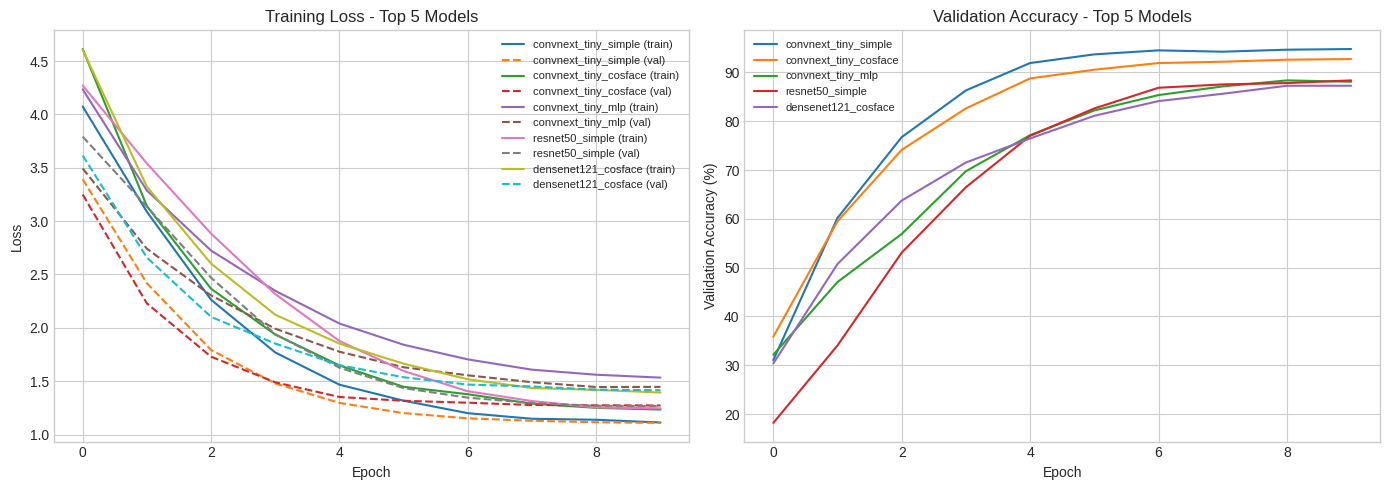

In [18]:
# Training curves for top 5 models
top_5_models = results_df.head(5)['Model'].tolist()

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

for model_name in top_5_models:
    history = all_results[model_name]['history']
    axes[0].plot(history['train_loss'], label=f"{model_name} (train)")
    axes[0].plot(history['val_loss'], '--', label=f"{model_name} (val)")

axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training Loss - Top 5 Models')
axes[0].legend(fontsize=8)

for model_name in top_5_models:
    history = all_results[model_name]['history']
    axes[1].plot(history['val_acc'], label=model_name)

axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Validation Accuracy (%)')
axes[1].set_title('Validation Accuracy - Top 5 Models')
axes[1].legend(fontsize=8)

plt.tight_layout()
plt.savefig(os.path.join(WORK_DIR, 'training_curves_top5.png'), dpi=150)
plt.show()

In [19]:
# Best model summary
best_model_name = results_df.iloc[0]['Model']
best_results = all_results[best_model_name]

print("\n" + "="*60)
print("BEST MODEL SUMMARY")
print("="*60)
print(f"Model:           {best_model_name}")
print(f"Backbone:        {best_results['backbone']}")
print(f"Classifier Head: {best_results['head']}")
print(f"")
print(f"Training Accuracy:    {best_results['final_train_acc']:.2f}%")
print(f"Validation Accuracy:  {best_results['best_val_acc']:.2f}%")
print(f"Top-5 Accuracy:       {best_results['final_val_top5']:.2f}%")
print(f"F1 Score:             {best_results['final_val_f1']:.4f}")
print("="*60)


BEST MODEL SUMMARY
Model:           convnext_tiny_simple
Backbone:        convnext_tiny
Classifier Head: simple

Training Accuracy:    96.98%
Validation Accuracy:  94.80%
Top-5 Accuracy:       97.81%
F1 Score:             0.9466


## 6. Save Best Model for Video Inference

In [20]:
# Save best model in the format compatible with video inference
best_model_path = os.path.join(MODELS_DIR, 'best_face_recognition.pt')

best_save_dict = {
    'model_state_dict': all_model_states[best_model_name],
    'backbone': best_results['backbone'],
    'head': best_results['head'],
    'num_classes': num_classes,
    'class_names': class_names,
    'best_val_acc': best_results['best_val_acc'],
    'results': best_results
}

torch.save(best_save_dict, best_model_path)
print(f"Best model saved to: {best_model_path}")

# Also save class names as JSON
class_names_path = os.path.join(MODELS_DIR, 'class_names.json')
with open(class_names_path, 'w') as f:
    json.dump(class_names, f, indent=2)
print(f"Class names saved to: {class_names_path}")

Best model saved to: /kaggle/working/models/best_face_recognition.pt
Class names saved to: /kaggle/working/models/class_names.json


In [21]:
# Save all results as JSON
all_results_json = []
for name, res in all_results.items():
    all_results_json.append({
        'model_name': name,
        'backbone': res['backbone'],
        'head': res['head'],
        'best_val_acc': res['best_val_acc'],
        'final_val_acc': res['final_val_acc'],
        'final_val_f1': res['final_val_f1'],
        'final_val_top5': res['final_val_top5'],
        'final_train_acc': res['final_train_acc'],
        'history': {
            'train_loss': res['history']['train_loss'],
            'train_acc': res['history']['train_acc'],
            'val_loss': res['history']['val_loss'],
            'val_acc': res['history']['val_acc']
        }
    })

results_path = os.path.join(WORK_DIR, 'all_model_results.json')
with open(results_path, 'w') as f:
    json.dump(all_results_json, f, indent=2)
print(f"All results saved to: {results_path}")

All results saved to: /kaggle/working/all_model_results.json


## 7. Test Best Model

In [22]:
import torch
import torch.nn as nn

class FaceClassifier(nn.Module):
    """Face identification model with configurable backbone and head."""
    
    def __init__(self, num_classes, backbone_name='resnet50', head_name='mlp', 
                 pretrained=True, dropout=0.5):
        super().__init__()
        self.backbone_name = backbone_name
        self.head_name = head_name
        self.num_classes = num_classes
        
        # Load backbone
        self.backbone, out_features = get_backbone(backbone_name, pretrained)
        
        # Create classifier head
        self.head = get_head(head_name, out_features, num_classes, dropout)
    
    def forward(self, x):
        features = self.backbone(x)
        if isinstance(features, tuple):
            features = features[0]
        return self.head(features)
    
    def predict(self, x):
        """Get predictions and probabilities."""
        self.eval()
        with torch.no_grad():
            logits = self.forward(x)
            probs = F.softmax(logits, dim=1)
            preds = logits.argmax(dim=1)
        return preds, probs


In [23]:
# Load and test best model
def load_best_model(checkpoint_path, device):
    """Load the best model from checkpoint."""
    # Use weights_only=False for trusted checkpoints saved with extra metadata
    checkpoint = torch.load(checkpoint_path, map_location=device, weights_only=False)
    
    model = FaceClassifier(
        num_classes=checkpoint['num_classes'],
        backbone_name=checkpoint['backbone'],
        head_name=checkpoint['head'],
        pretrained=False
    )
    model.load_state_dict(checkpoint['model_state_dict'])
    model = model.to(device)
    model.eval()
    
    return model, checkpoint['class_names']

# Load model (use existing best_model_path and device)
best_model, loaded_class_names = load_best_model(best_model_path, device)
print(f"Best model loaded successfully!")
print(f"Number of classes: {len(loaded_class_names)}")

Best model loaded successfully!
Number of classes: 100


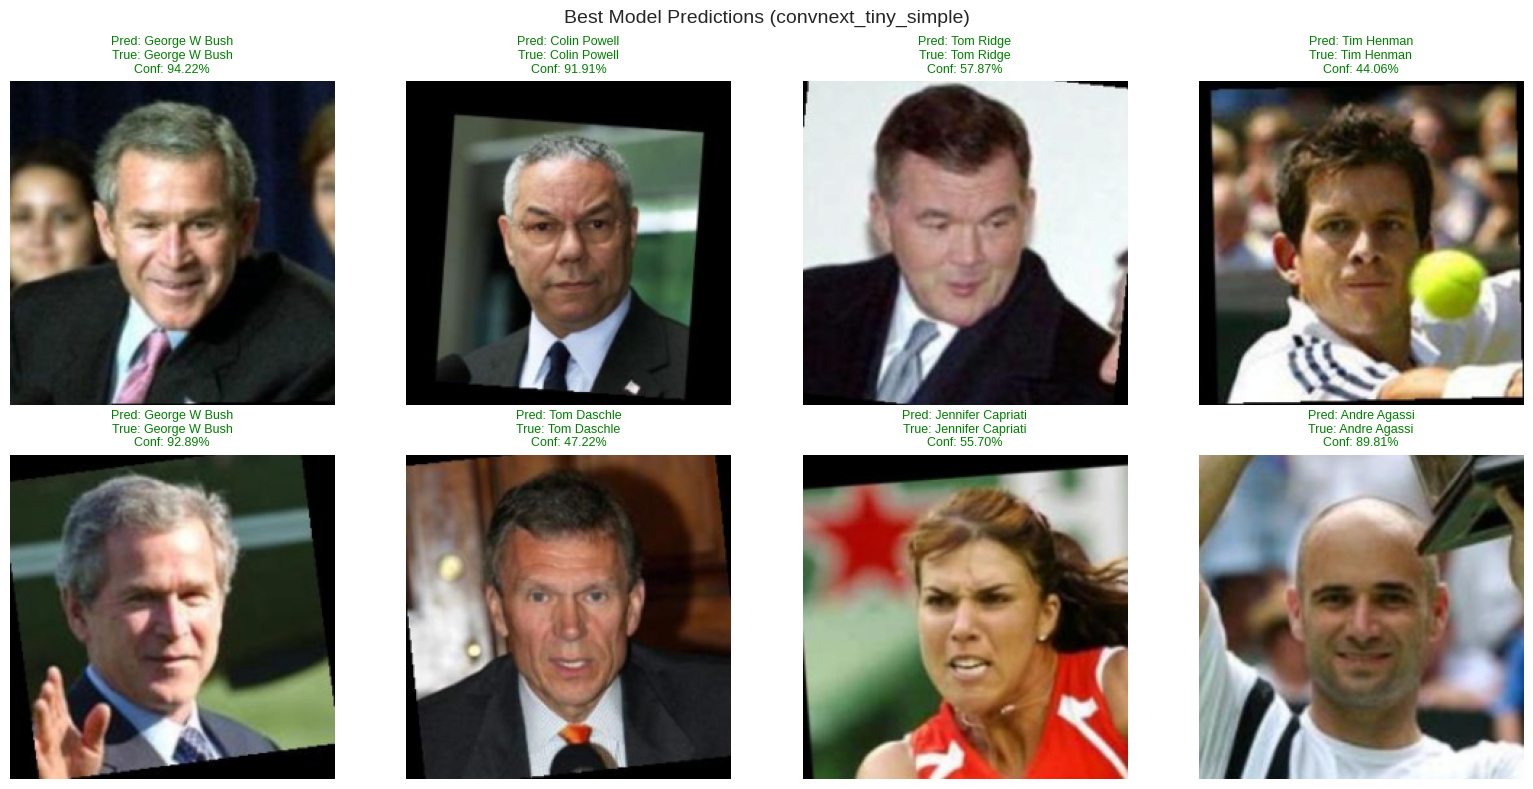

In [24]:
# Visualize predictions
best_model.eval()
images, labels = next(iter(val_loader))
images = images.to(device)

preds, probs = best_model.predict(images)

fig, axes = plt.subplots(2, 4, figsize=(16, 8))
for i, ax in enumerate(axes.flat):
    img = images[i].cpu().permute(1, 2, 0).numpy()
    img = img * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]
    img = np.clip(img, 0, 1)
    
    ax.imshow(img)
    pred_name = class_names[preds[i].item()].replace('_', ' ')
    true_name = class_names[labels[i].item()].replace('_', ' ')
    conf = probs[i, preds[i]].item()
    
    color = 'green' if preds[i].item() == labels[i].item() else 'red'
    ax.set_title(f'Pred: {pred_name}\nTrue: {true_name}\nConf: {conf:.2%}', color=color, fontsize=9)
    ax.axis('off')

plt.suptitle(f'Best Model Predictions ({best_model_name})', fontsize=14)
plt.tight_layout()
plt.savefig(os.path.join(WORK_DIR, 'best_model_predictions.png'), dpi=150)
plt.show()

## 8. Usage for Video Inference

The saved model is compatible with the video face recognition pipeline.

```python
# Load model for video inference
import torch
from facenet_pytorch import MTCNN

# Load checkpoint
checkpoint = torch.load('models/best_face_recognition.pt')

# Create model
model = FaceClassifier(
    num_classes=checkpoint['num_classes'],
    backbone_name=checkpoint['backbone'],
    head_name=checkpoint['head'],
    pretrained=False
)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

# Face detector
mtcnn = MTCNN(keep_all=True, device='cuda')

# Use with VideoFaceRecognizer from video_face_recognition.ipynb
```

In [25]:
print("\n" + "="*60)
print("TRAINING COMPLETE!")
print("="*60)
print(f"\nTotal models trained: {len(all_results)}")
print(f"Best model: {best_model_name}")
print(f"Best accuracy: {best_results['best_val_acc']:.2f}%")
print(f"\nFiles saved:")
print(f"  - {best_model_path}")
print(f"  - {class_names_path}")
print(f"  - {results_path}")
print(f"  - Individual model checkpoints in {MODELS_DIR}/")


TRAINING COMPLETE!

Total models trained: 25
Best model: convnext_tiny_simple
Best accuracy: 94.80%

Files saved:
  - /kaggle/working/models/best_face_recognition.pt
  - /kaggle/working/models/class_names.json
  - /kaggle/working/all_model_results.json
  - Individual model checkpoints in /kaggle/working/models/
